# Импортирование необходимых библиотек

In [26]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math, re
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
from scipy.stats import skew, mode, kurtosis, norm
import pandas as pd
import seaborn as sns
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

import csv, json, codecs, sys
import urllib.request
import urllib.error
import pandas as pd
import pickle, random

import requests
from bs4 import BeautifulSoup

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

config = SHConfig()

In [6]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

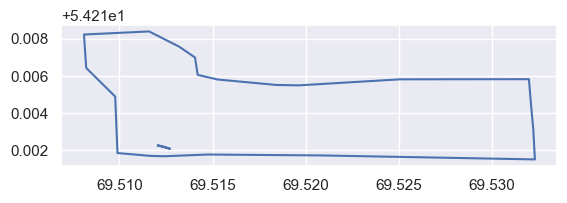

In [7]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [8]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [9]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Составление маски пастбища

In [10]:
aoi_height, aoi_width = pasture_size[-1], pasture_size[0]

In [11]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

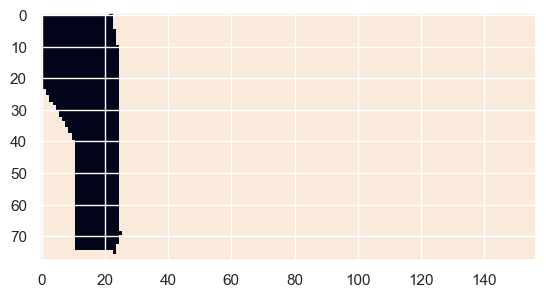

In [12]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

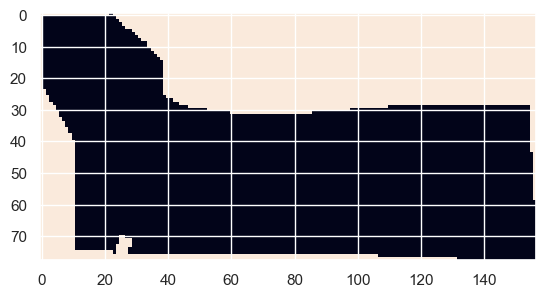

In [13]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [14]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def get_only_zagon(index, zagon):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=masks[zagon-1].reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

bands_dict = dict()

# Анализ погодных параметров и каналов

In [15]:
training_df = pd.read_csv("train_data.csv")
training_df

,time,greenmass,zagon
0,2022-06-09,0.80,2
1,2022-06-09,1.00,3
2,2022-06-09,1.20,5
3,2022-06-09,1.10,6
4,2022-07-14,1.40,2
5,2022-07-14,1.20,3
6,2022-08-03,2.20,4
7,2022-08-03,1.90,5
8,2022-08-03,0.90,6
9,2022-08-03,0.60,7


In [16]:
data_collection = DataCollection.SENTINEL2_L2A
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

universal_bands_dict = dict([(band, i) for i, band in enumerate(["AOT", "SNW", "CLD", "SCL", "CLP", "CLM", "dataMask"])])

# Дополнительная вспомогательная функция для сбора данных ДЗЗ

In [44]:
def get_date_data(date_chosen, zagon, greenmass, collection, by_pasture=True):
    global bands_dict
    
    year = f"{date_chosen[:4]}"

    # LOADINGS
    with open(f'results_{year}.pkl', 'rb') as f:
        results = pickle.load(f)

    with open(f'uni_bands_data_{year}.pkl', 'rb') as f:
        uni_bands_data = pickle.load(f)

    with open(f'all_bands_data_{year}.pkl', 'rb') as f:
        all_bands_data = pickle.load(f)

    with open(f'aux_data_{year}.pkl', 'rb') as f:
        aux_data = pickle.load(f)

    with open(f'unique_acquisitions_{year}.pkl', 'rb') as f:
        unique_acquisitions = pickle.load(f)         


    white_noise_threshold = 255 # Значение [0-255]
    white_noise_count = 12246 # Количество 157*78=[0-12246]

    clear_date_dict = []
    for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

        data = image.astype(np.float64) / image.max()
        data = 255 * data
        image = data.astype(np.uint8)

        mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
        comb = mx1&mx2&mx3
        white_image = comb >= white_noise_threshold
        if white_image.sum() <= white_noise_count:
            clear_date_dict.append((str(timestamp.date().isoformat()), i))

    clear_date_dict = dict(clear_date_dict)
    image_date = clear_date_dict[date_chosen]

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B01"]],zagon)))

        BLUE = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B02"]],zagon)))
        GREEN = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B03"]],zagon)))
        RED = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B04"]],zagon)))

        RED_EDGE1 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B05"]],zagon)))
        RED_EDGE2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B06"]],zagon)))
        RED_EDGE3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B07"]],zagon)))

        NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B08"]],zagon)))
        N_NIR = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B8A"]],zagon)))
        WV = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B09"]],zagon)))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B10"]],zagon)))
        SWIR2 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B11"]],zagon)))
        SWIR3 = normalize(brighten(get_only_zagon(all_bands_data[image_date][:, :, bands_dict["B12"]],zagon)))

    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])),zagon)

        BLUE = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])),zagon)
        GREEN = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])),zagon)
        RED = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])),zagon)

        RED_EDGE1 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])),zagon)
        RED_EDGE2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])),zagon)
        RED_EDGE3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])),zagon)

        NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])),zagon)
        N_NIR = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])),zagon)
        WV = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])),zagon)
        if "B10" in bands_dict:
            SWIR_C = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])),zagon)
        SWIR2 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])),zagon)
        SWIR3 = get_only_zagon(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])),zagon)

    print(f"Успешно получены каналы для даты: {date_chosen} и загона №{zagon}")
    if "B10" in bands_dict:
        return ["time", "zagon", "greenmass"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, zagon, greenmass, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SZA, SAA, VZM, VAM]
    else:
        return ["time", "zagon", "greenmass"] + list(bands_dict.keys()) + list(aux_data_dict.keys()), [date_chosen, zagon, greenmass, ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR2, SWIR3, SZA, SAA, VZM, VAM]

# Получение данных ДЗЗ по доступным датам

In [45]:
from itertools import permutations, combinations, product
from math import factorial

In [46]:
# test_index = eval(formula_text)

# test_thresh = test_index.min() 
# #     test_thresh = (test_index.max() + test_index.min())/2
# # test_thresh = 0

# test_filter = test_index >= test_thresh; test_mask = ~test_filter
# test_meet = ma.masked_array(test_index, mask=test_mask)

# # lower_bound = -1;  upper_bound = 1
# lower_bound = test_meet.min(); upper_bound = test_meet.max()    
# mask = (test_meet < lower_bound) | (test_meet > upper_bound)

# test_meet = ma.masked_array(test_meet, mask=mask)

# ep.plot_bands(test_meet, title=f"Канал для даты: {date_chosen} и загона №{zagon}", cmap="viridis")

# #     test_meet = test_meet.mean()
# #     test_meet = ma.median(test_meet)
# test_meet = test_meet.sum()

In [70]:
sample_form = []
for index in training_df.index:
    data_lables, data_list = get_date_data(training_df.loc[index, 'time'], training_df.loc[index, 'zagon'], training_df.loc[index, 'greenmass'], "L1C", by_pasture=False)
    sample_form.append(data_list)    

Успешно получены каналы для даты: 2022-06-09 и загона №2
Успешно получены каналы для даты: 2022-06-09 и загона №3
Успешно получены каналы для даты: 2022-06-09 и загона №5
Успешно получены каналы для даты: 2022-06-09 и загона №6
Успешно получены каналы для даты: 2022-07-14 и загона №2
Успешно получены каналы для даты: 2022-07-14 и загона №3
Успешно получены каналы для даты: 2022-08-03 и загона №4
Успешно получены каналы для даты: 2022-08-03 и загона №5
Успешно получены каналы для даты: 2022-08-03 и загона №6
Успешно получены каналы для даты: 2022-08-03 и загона №7
Успешно получены каналы для даты: 2023-05-15 и загона №2
Успешно получены каналы для даты: 2023-05-22 и загона №3
Успешно получены каналы для даты: 2023-06-09 и загона №6
Успешно получены каналы для даты: 2023-06-14 и загона №7
Успешно получены каналы для даты: 2023-07-04 и загона №3
Успешно получены каналы для даты: 2023-07-09 и загона №4
Успешно получены каналы для даты: 2023-07-14 и загона №5


In [71]:
indices_df = pd.DataFrame(sample_form, columns=data_lables)

In [72]:
formula_types = {
    "term1": 1,
    
    "term1+term2": 2,
    "term1-term2": 2,
    
    "term1/term2": 2,
    "term1*term2": 2,
    
    "term1/term2 * term3": 3,
    
    "(term1-term2)/(term1+term2)": 2,
    
    "(term1+term2)/(term3+term4)": 4,
    
    "(term1+term2)/(term3-term4)": 4,
    "(term1-term2)/(term3-term4)": 4,
    
    "(term1-term2)/(term3-term4) * term5": 5,
}
methods = ["mean", "median", "harmonic", "geometric", "max", "min", "sum", "std_dev", "skewness_value", "IQR", "kurtosis_value"] # "std_dev", "skewness_value", "IQR", "kurtosis_value"
# methods = ["IQR", "kurtosis_value"]

combination_results = dict()
for formula_type, members in formula_types.items():
    combination_results[formula_type] = dict()
    for method in methods:
        combination_results[formula_type][method] = dict()
        for bands_combination in permutations(list(bands_dict.keys()), members):
            combination_results[formula_type][method][bands_combination] = dict()
            calculated_GM = []
            for sample in indices_df.index:
                replacer_terms = dict()
                
                for term in range(members):
                    exec(f'term{term+1} = indices_df.iloc[{sample}]["{bands_combination[term]}"]')
            
                formula = eval(formula_type)
                final_value = np.nan

                if method == "mean":
                    final_value = formula.mean()
                elif method == "median":
                    final_value = ma.median(formula)
                elif method == "harmonic":
                    try:
                        final_value = hmean(formula.reshape(formula.shape[1] * formula.shape[0]))
                    except ValueError:
                        final_value = np.nan
                elif method == "geometric":
                    try:
                        final_value = gmean(formula.reshape(formula.shape[1] * formula.shape[0]))
                    except ValueError:
                        final_value = np.nan
                elif method == "max":
                    final_value = formula.max()
                elif method == "min":
                    final_value = formula.min()
        
                elif method == "std_dev":
                    final_value = formula.std()
                elif method == "skewness_value":
                    final_value = skew(formula.compressed())
                elif method == "IQR":
                    try:
                        flattened_matrix = formula.compressed()
                        Q1 = np.percentile(flattened_matrix, 25)
                        Q3 = np.percentile(flattened_matrix, 75)
                        IQR = Q3 - Q1
                        final_value = IQR
                    except (IndexError, ValueError):
                        final_value = np.nan
                elif method == "kurtosis_value":
                    try:
                        flattened_matrix = formula.compressed()
                        kurtosis_value = kurtosis(flattened_matrix)
                        final_value = kurtosis_value
                    except (IndexError, ValueError):
                        final_value = np.nan                    
        
                else:
                    final_value = formula.sum()
                
                
                
                calculated_GM.append(final_value)

            combination_results[formula_type][method][bands_combination] = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]   

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_14584\1540379205.py:63: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  final_value = skew(formula.compressed())
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_14584\1540379205.py:76: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis_value = kurtosis(flattened_matrix)
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2616: UserWarning: Warning: converting 

In [73]:
# Create lists to store the data
formula_list = []
method_list = []
upper_highest_list = []
lower_highest_list = []

for formula_type, members in formula_types.items():
    for method in methods:
        upper_highest = list(sorted(combination_results[formula_type][method].items(), key=lambda item: item[1]))[0]
        lower_highest = list(sorted(combination_results[formula_type][method].items(), key=lambda item: item[1]))[-1]

        # Round the float values to a certain number of decimal places (e.g., 2)
        upper_highest = (upper_highest[0], round(upper_highest[1], 4))
        lower_highest = (lower_highest[0], round(lower_highest[1], 4))
        
        formula_list.append(formula_type)
        method_list.append(method)
        upper_highest_list.append(upper_highest)
        lower_highest_list.append(lower_highest)

# Create a DataFrame
df = pd.DataFrame({
    'Formula Type': formula_list,
    'Method': method_list,
    'Upper Highest': upper_highest_list,
    'Lower Highest': lower_highest_list
})

In [74]:
for i in df.index:
    print(i, df.iloc[i]["Upper Highest"], df.iloc[i]["Lower Highest"])

0 (('B12',), -0.7295) (('B11',), nan)
1 (('B12',), -0.7463) (('B11',), nan)
2 (('B12',), -0.7278) (('B11',), nan)
3 (('B12',), -0.7287) (('B11',), nan)
4 (('B03',), -0.3639) (('B12',), nan)
5 (('B04',), -0.5726) (('B11',), nan)
6 (('B04',), -0.4698) (('B09',), -0.086)
7 (('B05',), -0.2852) (('B12',), 0.6115)
8 (('B02',), 0.0356) (('B12',), nan)
9 (('B09',), -0.3429) (('B12',), 0.6234)
10 (('B06',), -0.3129) (('B12',), nan)
11 (('B11', 'B12'), -0.7295) (('B11', 'B09'), 0.2657)
12 (('B11', 'B12'), -0.7463) (('B09', 'B08'), 0.3233)
13 (('B11', 'B12'), -0.7287) (('B11', 'B09'), 0.2698)
14 (('B11', 'B12'), -0.7291) (('B11', 'B09'), 0.2677)
15 (('B03', 'B06'), -0.4792) (('B12', 'B11'), nan)
16 (('B01', 'B04'), -0.6126) (('B11', 'B08'), 0.2849)
17 (('B01', 'B04'), -0.503) (('B09', 'B8A'), -0.0933)
18 (('B05', 'B09'), -0.515) (('B12', 'B8A'), 0.6406)
19 (('B03', 'B12'), 0.0037) (('B12', 'B11'), nan)
20 (('B05', 'B8A'), -0.3886) (('B12', 'B08'), 0.6609)
21 (('B06', 'B07'), -0.379) (('B12', 'B11

In [75]:
# Set display options to show all rows and columns without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [76]:
# Display the DataFrame
df

,Formula Type,Method,Upper Highest,Lower Highest
0,term1,mean,"((B12,), -0.7295)","((B11,), nan)"
1,term1,median,"((B12,), -0.7463)","((B11,), nan)"
2,term1,harmonic,"((B12,), -0.7278)","((B11,), nan)"
3,term1,geometric,"((B12,), -0.7287)","((B11,), nan)"
4,term1,max,"((B03,), -0.3639)","((B12,), nan)"
5,term1,min,"((B04,), -0.5726)","((B11,), nan)"
6,term1,sum,"((B04,), -0.4698)","((B09,), -0.086)"
7,term1,std_dev,"((B05,), -0.2852)","((B12,), 0.6115)"
8,term1,skewness_value,"((B02,), 0.0356)","((B12,), nan)"
9,term1,IQR,"((B09,), -0.3429)","((B12,), 0.6234)"


In [77]:
# Reset display options to default (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

In [78]:
df.to_excel("FormulasComparision.xlsx", index=False)

In [ ]:
# combination_results = dict()
# for bands_combination in permutations(list(bands_dict.keys()), 4):
#     calculated_GM = []
#     for sample in indices_df.index:
#         term1 = indices_df.iloc[sample][f"{bands_combination[0]}"]
#         term2 = indices_df.iloc[sample][f"{bands_combination[1]}"]
#         term3 = indices_df.iloc[sample][f"{bands_combination[2]}"]
#         term4 = indices_df.iloc[sample][f"{bands_combination[3]}"]

#         formula = (term1+term2)/(term3+term4)
#         final_value = ma.median(formula)
#         calculated_GM.append(final_value)

#     combination_results[bands_combination] = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]

# print("Всего комбинации: ", len(combination_results))    

In [ ]:
# dict(sorted(combination_results.items(), key=lambda item: item[1]))

In [ ]:
# dict(sorted(combination_results.items(), key=lambda item: item[1], reverse=True))

In [80]:
combination_results

{'term1': {'mean': {('B01',): -0.274154356595656,
   ('B02',): -0.30725954722219295,
   ('B03',): -0.37425100666679395,
   ('B04',): -0.5001579135599781,
   ('B05',): -0.4034513037382588,
   ('B06',): -0.16585377161057147,
   ('B07',): -0.05661518231266964,
   ('B08',): 0.08452406195302911,
   ('B8A',): 0.21217947792100045,
   ('B09',): 0.26572777682424054,
   ('B11',): nan,
   ('B12',): -0.7294776875471469},
  'median': {('B01',): -0.2910112583409781,
   ('B02',): -0.3120910918031106,
   ('B03',): -0.38584927765169413,
   ('B04',): -0.5146197428200054,
   ('B05',): -0.41574863979585974,
   ('B06',): -0.21436441974209564,
   ('B07',): -0.1011916081660774,
   ('B08',): 0.3147916378363909,
   ('B8A',): 0.3072577138486088,
   ('B09',): 0.3072577138486088,
   ('B11',): nan,
   ('B12',): -0.7463499246002849},
  'harmonic': {('B01',): -0.3463756429944091,
   ('B02',): -0.3136776914035408,
   ('B03',): -0.3802071169487714,
   ('B04',): -0.5150633312583917,
   ('B05',): -0.39122689811643485,
 

# Анализ перед обучением

In [ ]:
# # Calculate the correlation matrix
# correlation_matrix = input_df.corr()

# # Create a heatmap using seaborn
# plt.figure(figsize=(18, 16))
# sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f", linewidths=.5)

# plt.axvline(x=18, color='black', linewidth=2)
# plt.axvline(x=19, color='black', linewidth=2)

# plt.axhline(y=13, color='black', linewidth=2)
# plt.axhline(y=14, color='black', linewidth=2)

# plt.title("Correlation Matrix Plot")
# plt.show()

In [ ]:
# plt.plot(range(len(input_df.index)), input_df["index"]/100, label='Прогноз со спутника')
# plt.plot(range(len(input_df.index)), input_df["greenmass"], label='Наземные данные')
# # plt.plot(range(len(input_df.index)), input_df["sunZenithAngles"], label='SZA')

# plt.title('Урожайность реальная vs Урожайность прогноз')
# plt.legend()
# plt.show()

# Генетический алгоритм

In [ ]:
# def masked_matrix_median(masked_matrix):
#     return ma.median(masked_matrix)

# bands_matrices = indices_df.iloc[:,3:15]
# green_mass = indices_df.iloc[:,2:3]

# bands_matrices_median = bands_matrices.applymap(masked_matrix_median)

In [ ]:
# from itertools import permutations
# import numpy as np
# from deap import base, creator, tools, algorithms
# import pandas as pd
# import numpy.ma as ma

# # Set up DEAP framework for Genetic Algorithm
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

# toolbox = base.Toolbox()
# toolbox.register("indices", np.random.permutation, len(bands_dict))
# toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
# toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# def evaluate(individual):
#     bands_combination = [list(bands_dict.keys())[i] for i in individual[:4]]
    
#     calculated_GM = []
#     for sample in indices_df.index:
#         terms = [indices_df.iloc[sample][f"{band}"] for band in bands_combination]
#         formula = (terms[0] + terms[1]) / (terms[2] + terms[3])
#         final_value = ma.median(formula)
#         calculated_GM.append(final_value)
    
#     correlation = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]
#     return correlation,

# toolbox.register("evaluate", evaluate)
# toolbox.register("mate", tools.cxOrdered)
# toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
# toolbox.register("select", tools.selTournament, tournsize=3)

# if __name__ == "__main__":
#     # Assuming you have initialized your indices_df dataframe

#     # Set random seed for reproducibility
# #     np.random.seed(42)

#     # Create an initial population
#     population_size = 10
#     population = toolbox.population(n=population_size)

#     # Evaluate the entire population
#     fitnesses = list(map(toolbox.evaluate, population))
#     for ind, fit in zip(population, fitnesses):
#         ind.fitness.values = fit

#     # Crossover and mutation probabilities
#     cxpb, mutpb = 0.7, 0.2

#     # Number of generations
#     ngen = 5

#     # Statistics to collect during the optimization
#     stats = tools.Statistics(lambda ind: ind.fitness.values)
#     stats.register("max", np.max)

#     # Run the Genetic Algorithm
#     algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2*population_size,
#                               cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=stats, halloffame=None, verbose=True)

#     # Get the best individual and its fitness value
#     best_individual = tools.selBest(population, k=1)[0]
#     best_combination = [list(bands_dict.keys())[int(i)] for i in best_individual[:4]]
#     best_fitness = best_individual.fitness.values[0]

#     print("Лучшая комбинация каналов:", best_combination)
#     print("Лучшая корреляция:", best_fitness)

In [ ]:
# combination_results = dict()
# for bands_combination in permutations(list(bands_dict.keys()), 4):
#     calculated_GM = []
#     for sample in indices_df.index:
#         term1 = indices_df.iloc[sample][f"{bands_combination[0]}"]
#         term2 = indices_df.iloc[sample][f"{bands_combination[1]}"]
#         term3 = indices_df.iloc[sample][f"{bands_combination[2]}"]
#         term4 = indices_df.iloc[sample][f"{bands_combination[3]}"]

#         formula = (term1+term2)/(term3+term4)
#         final_value = ma.median(formula)
#         calculated_GM.append(final_value)

#     combination_results[bands_combination] = np.corrcoef(calculated_GM, list(indices_df["greenmass"]))[0, 1]

# Clarification of the code above:    
# 1) "indices_df" dataframe has 17 rows and 13 columns, namely: "greenmass" and 12 bands ("B01", "B02" ... and so on)
# 2) each band is a masked matrix of size (175, 78)
# 3) This code searches for the best possible combination of 4 bands out of 12 bands.
# 4) Correlation with "greenmass" column is assessed
# 5) bands_dict dictionary's keys contain bands' names as strings ("B01", "B02" ... and so on)

# Actually, it does fine. I was able to find a set of bands with a 90% correlation. So, my question is what kind of Machine Learning or Optimization Algorithm can do the same?

In [ ]:
# band = "B12"
# cmap = "viridis"
# for i in indices_df.index:
#     ep.plot_bands(indices_df.iloc[i][band], title=f"{indices_df.iloc[i]['time']} || {indices_df.iloc[i]['zagon']}", cmap=cmap)

In [79]:
indices = [
    "(NIR - RED) / (NIR + RED)",
    "2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)",
    "(NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5)",
    "((NIR - RED) / (NIR + RED))**(0.5)",
    "(NIR - GREEN) / (NIR + GREEN)",
    "(NIR - SWIR3) / (NIR + SWIR3)",
    "(NIR / RED) - 1",
    "(NIR / RED_EDGE1) - 1",
    "(RED_EDGE1 - RED) / (RED_EDGE1 + RED)",
    "(NIR - RED_EDGE1) / (NIR + RED_EDGE1)",
    "(NIR - (2 * RED) + BLUE) / (NIR + (2 * RED) + BLUE)",
    "(GREEN - RED) / (GREEN + RED - BLUE)",
    "(BLUE+NIR)/(RED+SWIR3)",
    "(NIR)/(SWIR3)",
    "(BLUE)/(RED)",
    "ULTRA_BLUE",
    "BLUE",
    "GREEN",
    "RED",
    "RED_EDGE1",
    "RED_EDGE2",
    "RED_EDGE3",
    "NIR",
    "N_NIR",
    "WV",
    "SWIR2",
    "SWIR3",
]

methods = ["mean", "median", "harmonic", "geometric", "max", "min", "sum", "std_dev", "skewness_value", "IQR", "kurtosis_value"]
russian_methods = ["средняя", "медианная", "гармон.", "геометр.", "макс.", "мин.", "сумма", "станд. откл.", "коэфф. ассим.", "межкварт. разм.", "коэфф. эксц.",]

def substitute_values(input_string):
    replacements = {
        'ULTRA_BLUE': 'indices_df.iloc[sample]["B01"]',
        'BLUE': 'indices_df.iloc[sample]["B02"]',
        'GREEN': 'indices_df.iloc[sample]["B03"]',
        'RED': 'indices_df.iloc[sample]["B04"]',
        'RED_EDGE1': 'indices_df.iloc[sample]["B05"]',
        'RED_EDGE2': 'indices_df.iloc[sample]["B06"]',
        'RED_EDGE3': 'indices_df.iloc[sample]["B07"]',
        'NIR': 'indices_df.iloc[sample]["B08"]',
        'N_NIR': 'indices_df.iloc[sample]["B8A"]',
        'WV': 'indices_df.iloc[sample]["B09"]',
        'SWIR2': 'indices_df.iloc[sample]["B11"]',
        'SWIR3': 'indices_df.iloc[sample]["B12"]',
    }

    # Use regular expressions to replace whole words only
    for key, value in replacements.items():
        pattern = r'\b{}\b'.format(re.escape(key))
        input_string = re.sub(pattern, value, input_string)
    
    return input_string

In [81]:
outer_layer = dict()
for index in indices:
    outer_layer[index] = dict()
    for method in methods:
        outer_layer[index][method] = dict()
        values = []
        for sample in indices_df.index:
            result = substitute_values(index).replace("sample", str(sample))
            if method == "mean":
                value = eval(result).mean()
            elif method == "median":
                value = ma.median(eval(result))
            elif method == "harmonic":
                try:
                    value = hmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
                except ValueError:
                    value = np.nan
            elif method == "geometric":
                try:
                    value = gmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
                except ValueError:
                    value = np.nan
            elif method == "max":
                value = eval(result).max()
            elif method == "min":
                value = eval(result).min()

                
            elif method == "std_dev":
                value = eval(result).std()
            elif method == "skewness_value":
                value = skew(eval(result).compressed())
            elif method == "IQR":
                try:
                    flattened_matrix = eval(result).compressed()
                    Q1 = np.percentile(flattened_matrix, 25)
                    Q3 = np.percentile(flattened_matrix, 75)
                    IQR = Q3 - Q1
                    value = IQR
                except (IndexError, ValueError):
                    value = np.nan
            elif method == "kurtosis_value":
                try:
                    flattened_matrix = eval(result).compressed()
                    kurtosis_value = kurtosis(flattened_matrix)
                    value = kurtosis_value
                except (IndexError, ValueError):
                    value = np.nan   

            else:
                value = eval(result).sum()
            
            values.append(value)
        outer_layer[index][method] = np.corrcoef(values, list(indices_df["greenmass"]))[0, 1]
            

C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
C:\ProgramData\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:307: RuntimeWarning: invalid value encountered in log
  log_a = np.log(a)
C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Пользователь\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_14584\1272458695.py:32: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  value = skew(eval(result).compressed())
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_14584\1272458695.py:45: 

In [82]:
pd.DataFrame(outer_layer).transpose()

,mean,median,harmonic,geometric,max,min,sum,std_dev,skewness_value,IQR,kurtosis_value
(NIR - RED) / (NIR + RED),0.548396,0.567964,0.542080,0.545483,0.572421,0.322224,0.385073,0.257590,-0.142502,0.358324,-0.157681
2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1),0.635350,0.658631,0.625618,0.630823,0.530787,0.371067,0.461844,0.252016,-0.199834,0.334146,-0.123146
(NIR - RED) / (NIR + RED + 0.5) * (1 + 0.5),0.548472,0.568371,0.543989,0.546450,0.561499,0.327790,0.368194,0.180589,-0.124117,0.272696,-0.136950
((NIR - RED) / (NIR + RED))**(0.5),0.522357,0.541445,0.519150,0.520800,0.564981,0.323398,0.223317,0.024825,-0.081403,0.148892,-0.121822
(NIR - GREEN) / (NIR + GREEN),0.398143,0.415020,0.396761,0.397479,0.322103,0.361863,0.182599,0.099116,-0.101918,0.144627,-0.098271
(NIR - SWIR3) / (NIR + SWIR3),0.724831,0.771272,NaN,NaN,0.575750,0.275820,0.730830,0.543398,0.220914,0.473794,-0.106142
(NIR / RED) - 1,0.653675,0.653943,0.617510,0.636979,0.625230,0.291525,0.589019,0.645092,0.104817,0.677423,0.085917
(NIR / RED_EDGE1) - 1,0.455255,0.504264,0.459665,0.452179,0.229703,0.328749,0.331842,-0.023256,-0.195149,0.020080,0.006943
(RED_EDGE1 - RED) / (RED_EDGE1 + RED),0.623832,0.634587,NaN,NaN,0.566445,0.376218,0.538184,0.567613,0.121476,0.713358,-0.148030
(NIR - RED_EDGE1) / (NIR + RED_EDGE1),0.440125,0.467606,0.411350,0.408245,0.305010,0.346468,0.292550,-0.191372,-0.165265,-0.170367,0.052607


In [41]:
# pd.DataFrame(outer_layer).transpose().to_excel("ComparisoinTable.xlsx")

In [40]:
# outer_layer = dict()

# # Assuming you have 17 rows and 7 columns
# total_rows = 25
# total_columns = 7

# # Calculate the height and width ratios for each subplot
# height_ratios = np.ones(total_rows)
# width_ratios = np.ones(total_columns)

# fig, axs = plt.subplots(len(indices), len(methods), gridspec_kw={'height_ratios': height_ratios, 'width_ratios': width_ratios}, figsize=(60, 130))

# for i, index in enumerate(indices):
#     outer_layer[index] = dict()
#     for m, method in enumerate(methods):
#         outer_layer[index][method] = dict()
#         values = []
#         for sample in indices_df.index:
#             result = substitute_values(index).replace("sample", str(sample))
#             if method == "mean":
#                 value = eval(result).mean()
#             elif method == "median":
#                 value = ma.median(eval(result))
#             elif method == "harmonic":
#                 try:
#                     value = hmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
#                 except ValueError:
#                     value = np.nan
#             elif method == "geometric":
#                 try:
#                     value = gmean(eval(result).reshape(eval(result).shape[1] * eval(result).shape[0]))
#                 except ValueError:
#                     value = np.nan
#             elif method == "max":
#                 value = eval(result).max()
#             elif method == "min":
#                 value = eval(result).min()
#             else:
#                 value = eval(result).sum()
            
#             values.append(value)
            
#         # Assuming value_x and value_y are your new variable names
#         value_x = np.array(values)
#         value_y = indices_df["greenmass"]
#         try:
#             # Assuming value_x and value_y are your new variable names
#             coefficients = np.polyfit(value_x, value_y, 1)
#             slope, intercept = coefficients
#             regression_line = slope * value_x + intercept

#             distances = np.abs(value_y - (slope * value_x + intercept)) / np.sqrt(slope**2 + 1)
#             mean_distance = np.mean(distances)

#             # Root Mean Squared Error (RMSE)
#             rmse = np.sqrt(np.mean(distances**2))

#             # R-squared (coefficient of determination)
#             mean_y = np.mean(value_y)
#             ss_total = np.sum((value_y - mean_y)**2)
#             ss_residual = np.sum(distances**2)
#             r_squared = 1 - (ss_residual / ss_total)

#             axs[i, m].scatter(value_x, value_y, marker='o', linestyle='-', label=f'Коэффициент детерминации (R^2): {r_squared:.2f}\nCреднеквадратичная ошибка (RMSE): {rmse:.2f}')
#             if intercept > 0:
#                 axs[i, m].plot(value_x, regression_line, color='red', label=f'Регрессионная прямая: $y = {slope:.2f}x +{intercept:.2f}$')
#             else:
#                 axs[i, m].plot(value_x, regression_line, color='red', label=f'Регрессионная прямая: $y = {slope:.2f}x {intercept:.2f}$')

#             axs[i, m].set_xlabel('Значения индекса (канала)')
#             axs[i, m].set_ylabel('Фактическая урожайность (т/га)')
#             axs[i, m].set_title(f'Корреляция данных: {index} -> ({russian_methods[m]})')

#             axs[i, m].legend()          
#         except Exception as error:
#             pass
# #             print(f'Ошибка данных {index} + {method}')
# #             print(error)
            
#         outer_layer[index][method] = np.corrcoef(values, list(indices_df["greenmass"]))[0, 1]
      
# plt.tight_layout()
# plt.show()            